## Credit Card Fraud Detection

The dataset for this use case is here - https://www.kaggle.com/datasets/kartik2112/fraud-detection

This is a simulated data using this simulation tool -  https://github.com/namebrandon/Sparkov_Data_Generation

### About the Dataset

This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.


### Business Requirements
Bank is looking for a way to identify a credit card transaction is fraud or not. This will save bank a lot of money and resources. Build a model which will classify the transaction as fraud or not  with  minimal cost.

A model should classify with a score of more than **80%**.




In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import time
from sklearn.exceptions import ConvergenceWarning

# import data processing libraries
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from category_encoders import TargetEncoder,JamesSteinEncoder

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,classification_report,balanced_accuracy_score,precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn import tree


# import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB,MultinomialNB

# balance the dataset
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler,KMeansSMOTE,ADASYN,BorderlineSMOTE,SMOTE


#import keras for deep neural networks models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

from sklearn_evaluation import plot
import graphviz

import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore',category=ConvergenceWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
ConvergenceWarning('ignore')

#intel sklearn extensions
from sklearnex import patch_sklearn
patch_sklearn()

2023-12-22 10:05:47.399883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Introduction
We have 2 datasets one for training and the other one for testing the model. Lets load training dataset and do data analysis and model building on it.
The datasets are
* [Train Set](data/fraudTrain.csv)
* [Test Set](data/fraudTest.csv)

Lets use train set to evaluate models and figure out the best model then validate that model using test dataset once the model is trained with train set.

### Dataset


In [2]:
card_transaction_df = pd.read_csv('data/fraudTrain.csv')
card_transaction_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Data Understanding

In [3]:
card_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

This dataset contains 1.3M rows with  22 features. The dataset contains object,float and int type features.

In [4]:
card_transaction_df.duplicated().sum()

0

This dataset doesnt contains any duplicated rows to remove.

In [5]:
card_transaction_df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

This dataset also doesnt contains any nulls so we dont have to impute any features.

In [6]:
card_transaction_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06
mean,648337,4.17192e+17,70.351,48800.7,38.5376,-90.2263,88824.4,1.34924e+09,38.5373,-90.2265,0.00578865
std,374318,1.30881e+18,160.316,26893.2,5.07581,13.7591,301956,1.28413e+07,5.10979,13.7711,0.0758627
min,0,6.04162e+10,1,1257,20.0271,-165.672,23,1.32538e+09,19.0278,-166.671,0
25%,324168,1.80043e+14,9.65,26237,34.6205,-96.798,743,1.33875e+09,34.7336,-96.8973,0
50%,648337,3.52142e+15,47.52,48174,39.3543,-87.4769,2456,1.34925e+09,39.3657,-87.4384,0
75%,972506,4.64226e+15,83.14,72042,41.9404,-80.158,20328,1.35939e+09,41.9572,-80.2368,0
max,1.29667e+06,4.99235e+18,28948.9,99783,66.6933,-67.9503,2.9067e+06,1.37182e+09,67.5103,-66.9509,1


In this dataset, the minimum transaction amount is $1 and the maximum is $28948.

In [7]:
card_transaction_df['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

This dataset has around 7500 fraud transactions and 1.28M non-fraud transactions which is 0.5% of the dataset.

### Data Analysis
Lets do some data analysis to understand how these features are related and what story they tell us.

#### Univariate Analysis

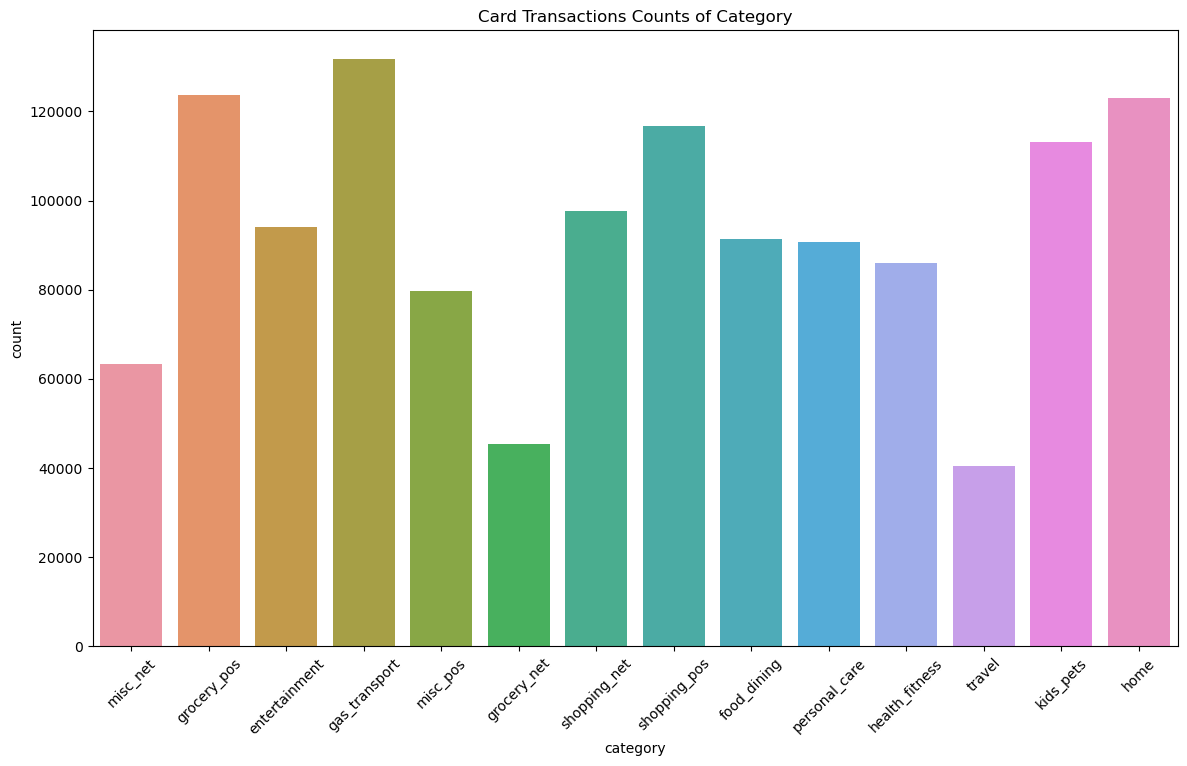

In [8]:
plt.figure(figsize=(14,8))
sns.countplot(card_transaction_df,x='category')
plt.xticks(rotation=45)
plt.title('Card Transactions Counts of Category')
plt.show()

Grocery, gas and home related transactions are hit with fraud a lot than other categories.

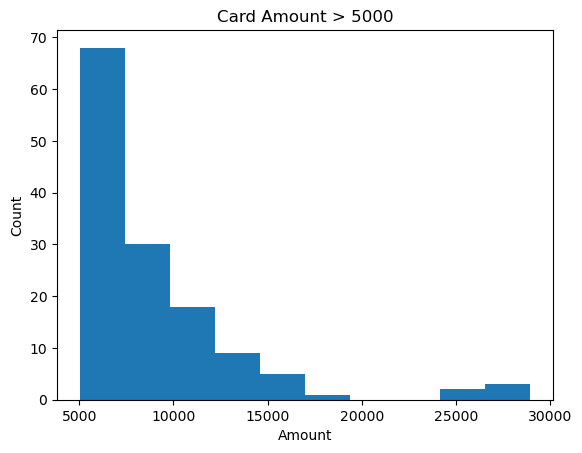

In [9]:
plt.title('Card Amount > 5000')
plt.hist(card_transaction_df.query("amt > 5000" )['amt'])
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

The above plot shows that the transaction amount distribution of amount > $5000. And the below plots shows the other range of amount > 1000 and < 5000 , < 1000.

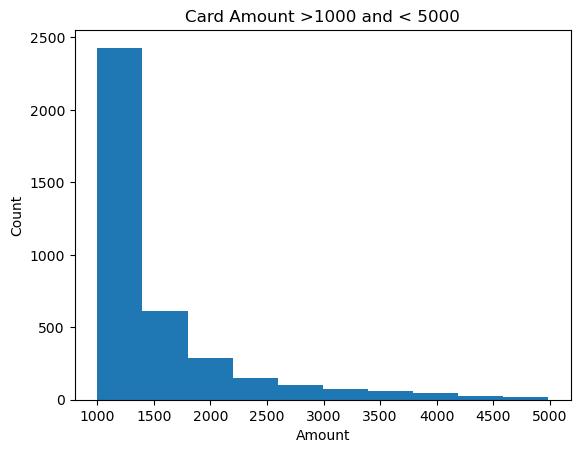

In [10]:
plt.title('Card Amount >1000 and < 5000')
plt.hist(card_transaction_df.query("amt < 5000 and amt > 1000" )['amt'])
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

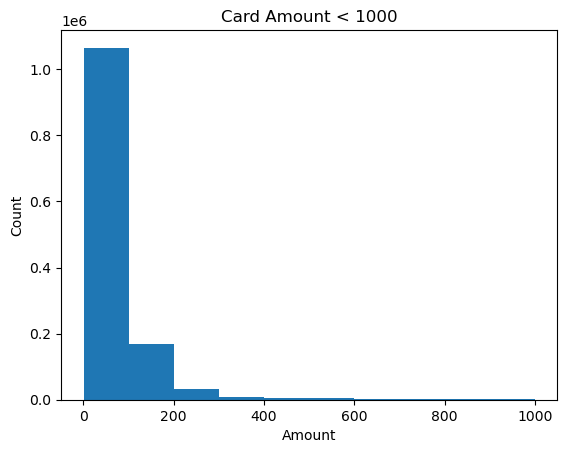

In [11]:
plt.title('Card Amount < 1000')
plt.hist(card_transaction_df.query("amt < 1000" )['amt'])
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

It seems a lot of transactions are in the amount < $1000 only.

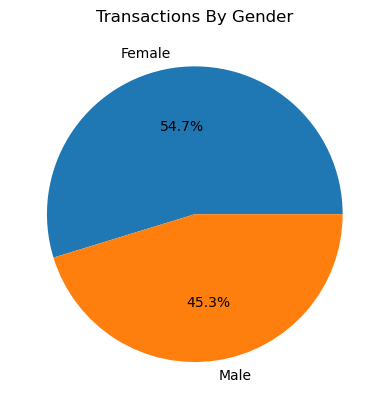

In [12]:
plt.title('Transactions By Gender')
plt.pie(card_transaction_df['gender'].value_counts(),labels=['Female','Male'],autopct='%1.1f%%')
plt.show()

This dataset has almost even distribution of gender with male and female.

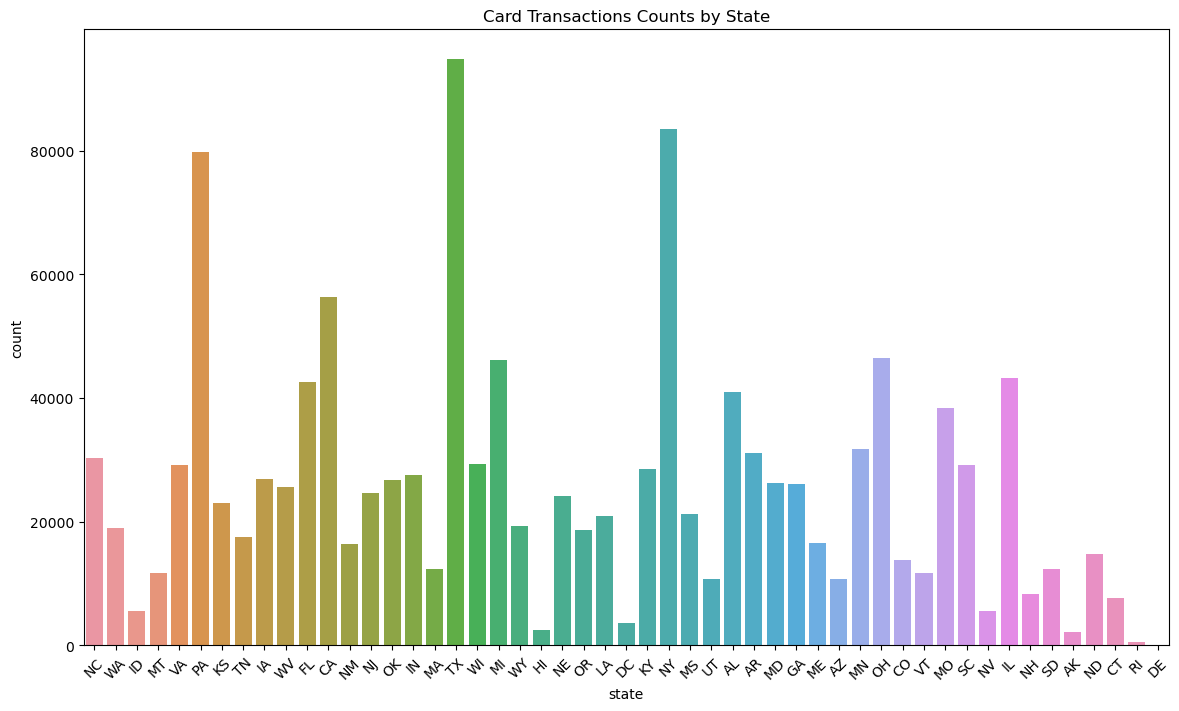

In [13]:
plt.figure(figsize=(14,8))
sns.countplot(card_transaction_df,x='state')
plt.xticks(rotation=45)
plt.title('Card Transactions Counts by State')
plt.show()

It seems PA,TX and NY states are having more transactions than other states.

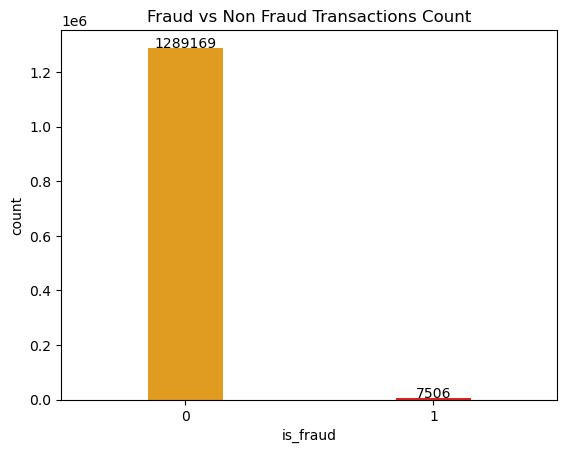

In [14]:
plot = sns.countplot(card_transaction_df,x='is_fraud',width=0.3,palette=['orange',"red"])
plot.text(0,len(card_transaction_df.query("is_fraud == 0")),len(card_transaction_df.query("is_fraud == 0")),horizontalalignment='center')
plot.text(1,len(card_transaction_df.query("is_fraud == 1")),len(card_transaction_df.query("is_fraud == 1")),horizontalalignment='center')
plt.title('Fraud vs Non Fraud Transactions Count')
plt.show()

In the dataset of 1.2M records there are only 7500 are fraud transactions.

#### Multivariate Analysis
Lets do some more analysis comparing with multiple features

<Figure size 1800x800 with 0 Axes>

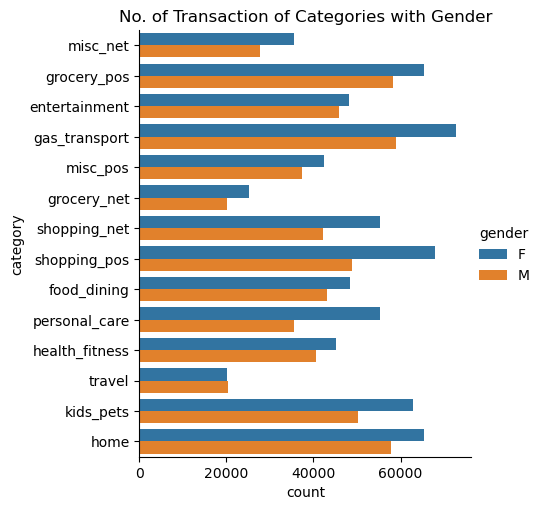

In [15]:
plt.figure(figsize=(18,8))
sns.catplot(data=card_transaction_df,y='category',kind='count',hue='gender')
plt.title('No. of Transaction of Categories with Gender')
plt.show()

The above plot shows that male and female are doing transactions more or less same in all categories.

In [16]:
# create a fraud transactions dataframe to analyze multivariate analysis
fraud_transactions_df = card_transaction_df.query("is_fraud == 1")

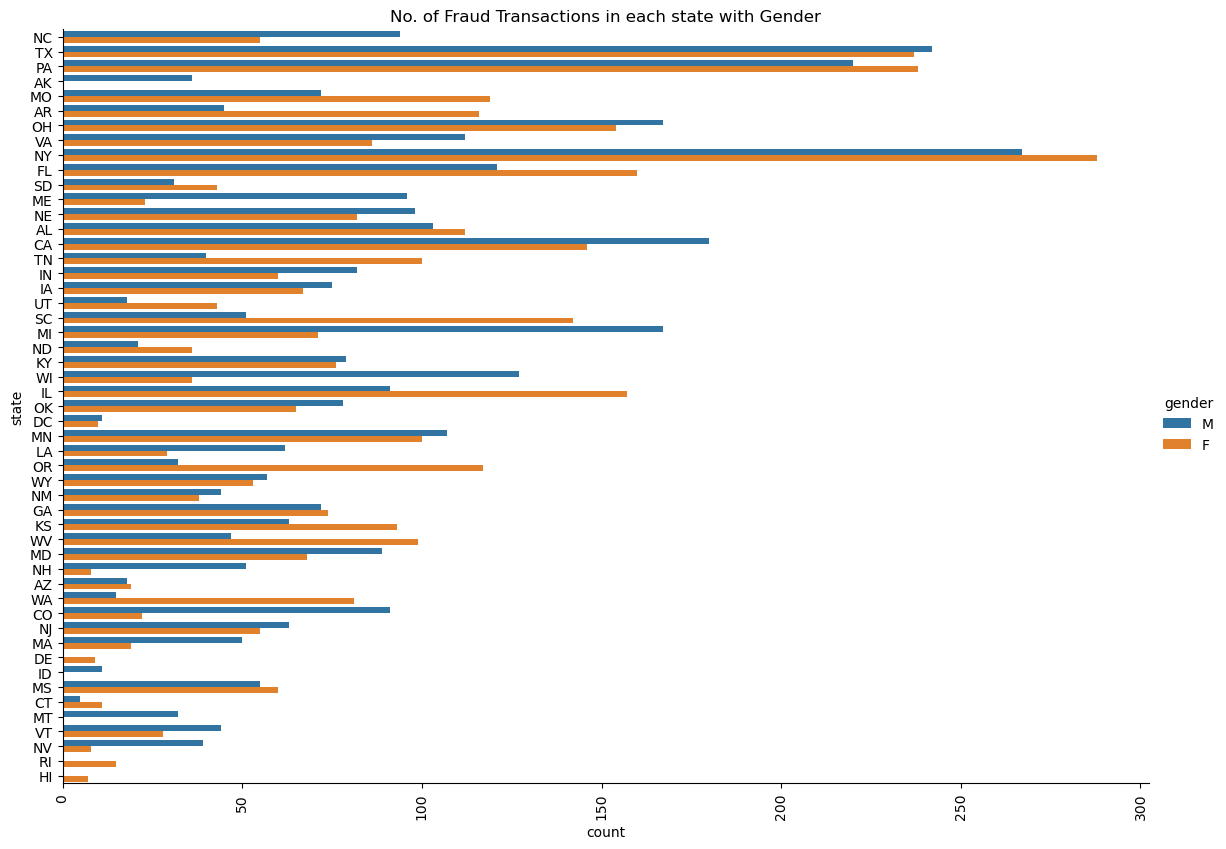

In [17]:
sns.catplot(data=fraud_transactions_df,y='state',kind='count',hue='gender',height=8.27, aspect=11.7/8.27)
plt.title('No. of Fraud Transactions in each state with Gender')
plt.xticks(rotation=90)
plt.show()

The above plot shows TX, PA and NY has a lot of fraud transactions than other states.

<Figure size 1800x800 with 0 Axes>

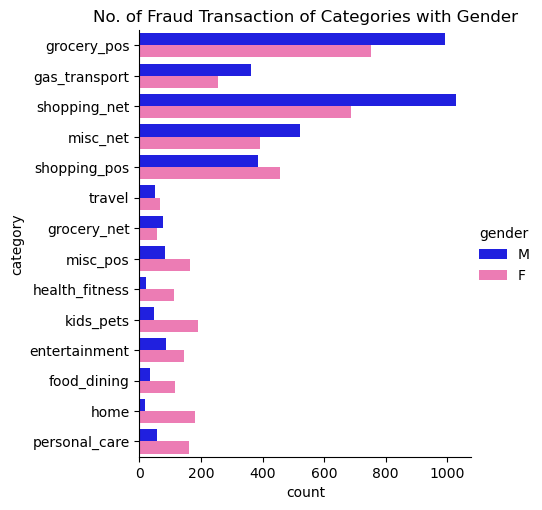

In [18]:
plt.figure(figsize=(18,8))
sns.catplot(data=fraud_transactions_df,y='category',kind='count',hue='gender',palette=['blue','hotpink'])
plt.title('No. of Fraud Transaction of Categories with Gender')
plt.show()

The above plot shows there are more fraud transactions groceries, internet shopping and general categories.

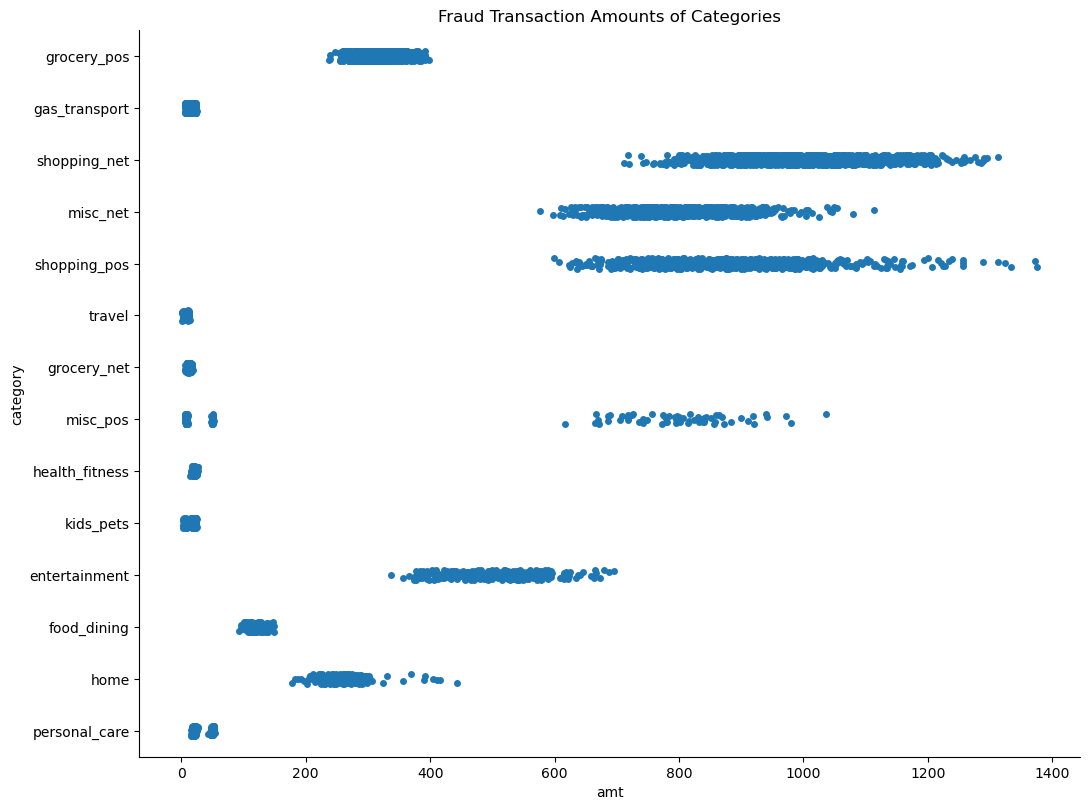

In [19]:
sns.catplot(data=fraud_transactions_df,y='category',x='amt',height=8, aspect=11/8)
plt.title('Fraud Transaction Amounts of Categories')
plt.show()

The above plot shows all of the fraud transactions with amount less than 1400 only.

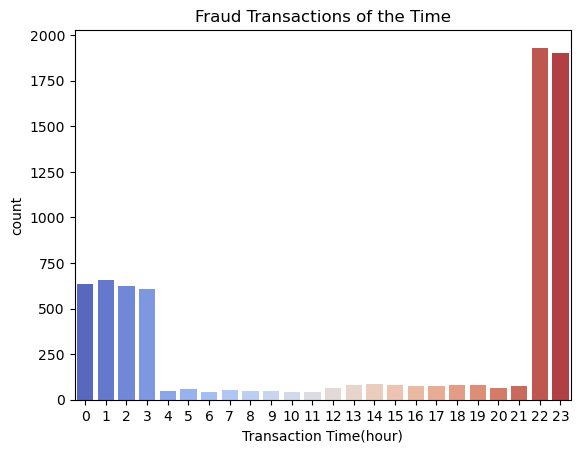

In [20]:
# convert the transaction date time into buckets of the day

sns.countplot(data=fraud_transactions_df,x=pd.to_datetime(fraud_transactions_df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour,
              palette="coolwarm").set_title('Fraud Transactions of the Time')
plt.xlabel('Transaction Time(hour)')
plt.show()

The above plot shows that the fraud transactions are happening during mid nigh times like in 22,23 hours of the day.

In [30]:

fig = px.scatter_mapbox(data_frame=fraud_transactions_df,hover_name='state',lat='lat',lon='long',zoom=3,
                        mapbox_style='open-street-map',text='state')
fig.update_layout(margin={'r':0,'l':0,'t':0,'b':0},title='Fraud Transactions Map Plot')
fig.show()

The above geo plot shows that there are fraud transactions in almost every state of the US.

### Feature Engineering
Lets cleanup the data from the dataset which are not really useful in model building, transform features, create new features, encoding categorical features etc ...

#### Drop columns
Lets drop columns which are not necessary help in classifying a transaction as fraud. The columns are 'Unnamed: 0','cc_num','trans_num','first','last','merchant','zip','city_pop','street','unix_time'.

In [21]:
#drop columns cc_num,trans_num, first and last as these columns may not add value in classifying a transaction as fraud.
cleaned_up_df = card_transaction_df.drop(columns=['Unnamed: 0','cc_num','trans_num','first','last','merchant','zip','city_pop','street','unix_time'],axis=1)

#### Adding Features

##### Add 'transaction_hour'
Lets add **transaction_hour** from the transaction date time as it seems lot of frauds are happening over night and with that we can infer accurately. And then drop the trans_date_trans_time column.

In [22]:
# adding 'Hour' column as it might help in frauds as many frauds are happening overnight.
cleaned_up_df['transaction_hour'] = pd.to_datetime(card_transaction_df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour
#now we can drop 'trans_date_trans_time' column.
cleaned_up_df.drop('trans_date_trans_time',axis=1,inplace=True)

##### Add 'age'
Add **age** of the transaction person using **dob** feature as it seems over aged people are target for frauds. And then drop the **dob** column.

In [23]:
current_year = datetime.date.today().year
cleaned_up_df['customer_age'] = current_year - pd.to_datetime(cleaned_up_df['dob']).dt.year
#drop the 'dob' column
cleaned_up_df.drop('dob',axis=1,inplace=True)
cleaned_up_df.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,is_fraud,transaction_hour,customer_age
0,misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,"Psychologist, counselling",36.011293,-82.048315,0,0,35
1,grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,Special educational needs teacher,49.159047,-118.186462,0,0,45
2,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,Nature conservation officer,43.150704,-112.154481,0,0,61
3,gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,Patent attorney,47.034331,-112.561071,0,0,56
4,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,Dance movement psychotherapist,38.674999,-78.632459,0,0,37


In [24]:
X = cleaned_up_df.drop('is_fraud',axis=1)
y = cleaned_up_df['is_fraud']

#### Categorical Encoding

In [25]:
X = JamesSteinEncoder().fit_transform(X,y)
X.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,transaction_hour,customer_age
0,0.009233,4.97,0.005262,0.00000,0.005305,36.0788,-81.1781,0.002619,36.011293,-82.048315,0,35
1,0.009126,107.23,0.005262,0.00000,0.005394,48.8878,-118.2105,0.003142,49.159047,-118.186462,0,45
2,0.003320,220.11,0.006426,0.00000,0.002919,42.1808,-112.2620,0.008497,43.150704,-112.154481,0,61
3,0.005109,45.00,0.006426,0.00985,0.003666,46.2306,-112.1138,0.006689,47.034331,-112.561071,0,56
4,0.003928,41.96,0.006426,0.00000,0.006262,38.4207,-79.4629,0.000000,38.674999,-78.632459,0,37


Encoded all the categorical features using **JamesSteinEncoder**.

#### Feature Importance

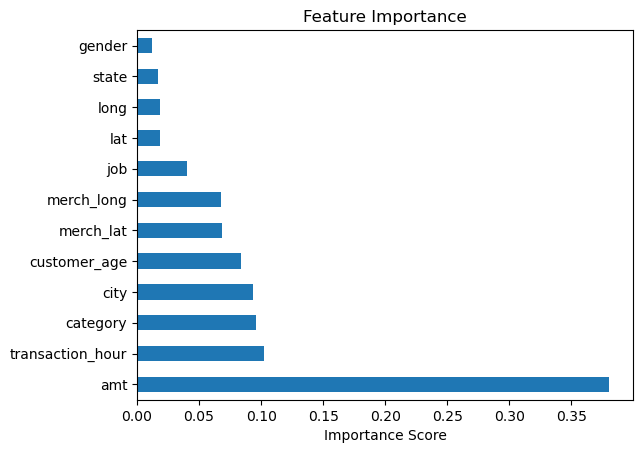

In [39]:
model = ExtraTreesClassifier(n_jobs=-1).fit(X,y)
feature_imp = pd.Series(model.feature_importances_, index=X.columns)
feature_imp.nlargest(20).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

It seems amount, transaction hour, category and city, age are most important in classifying the fraud than other features. This plot will help us figure out what features we can use to train the model.

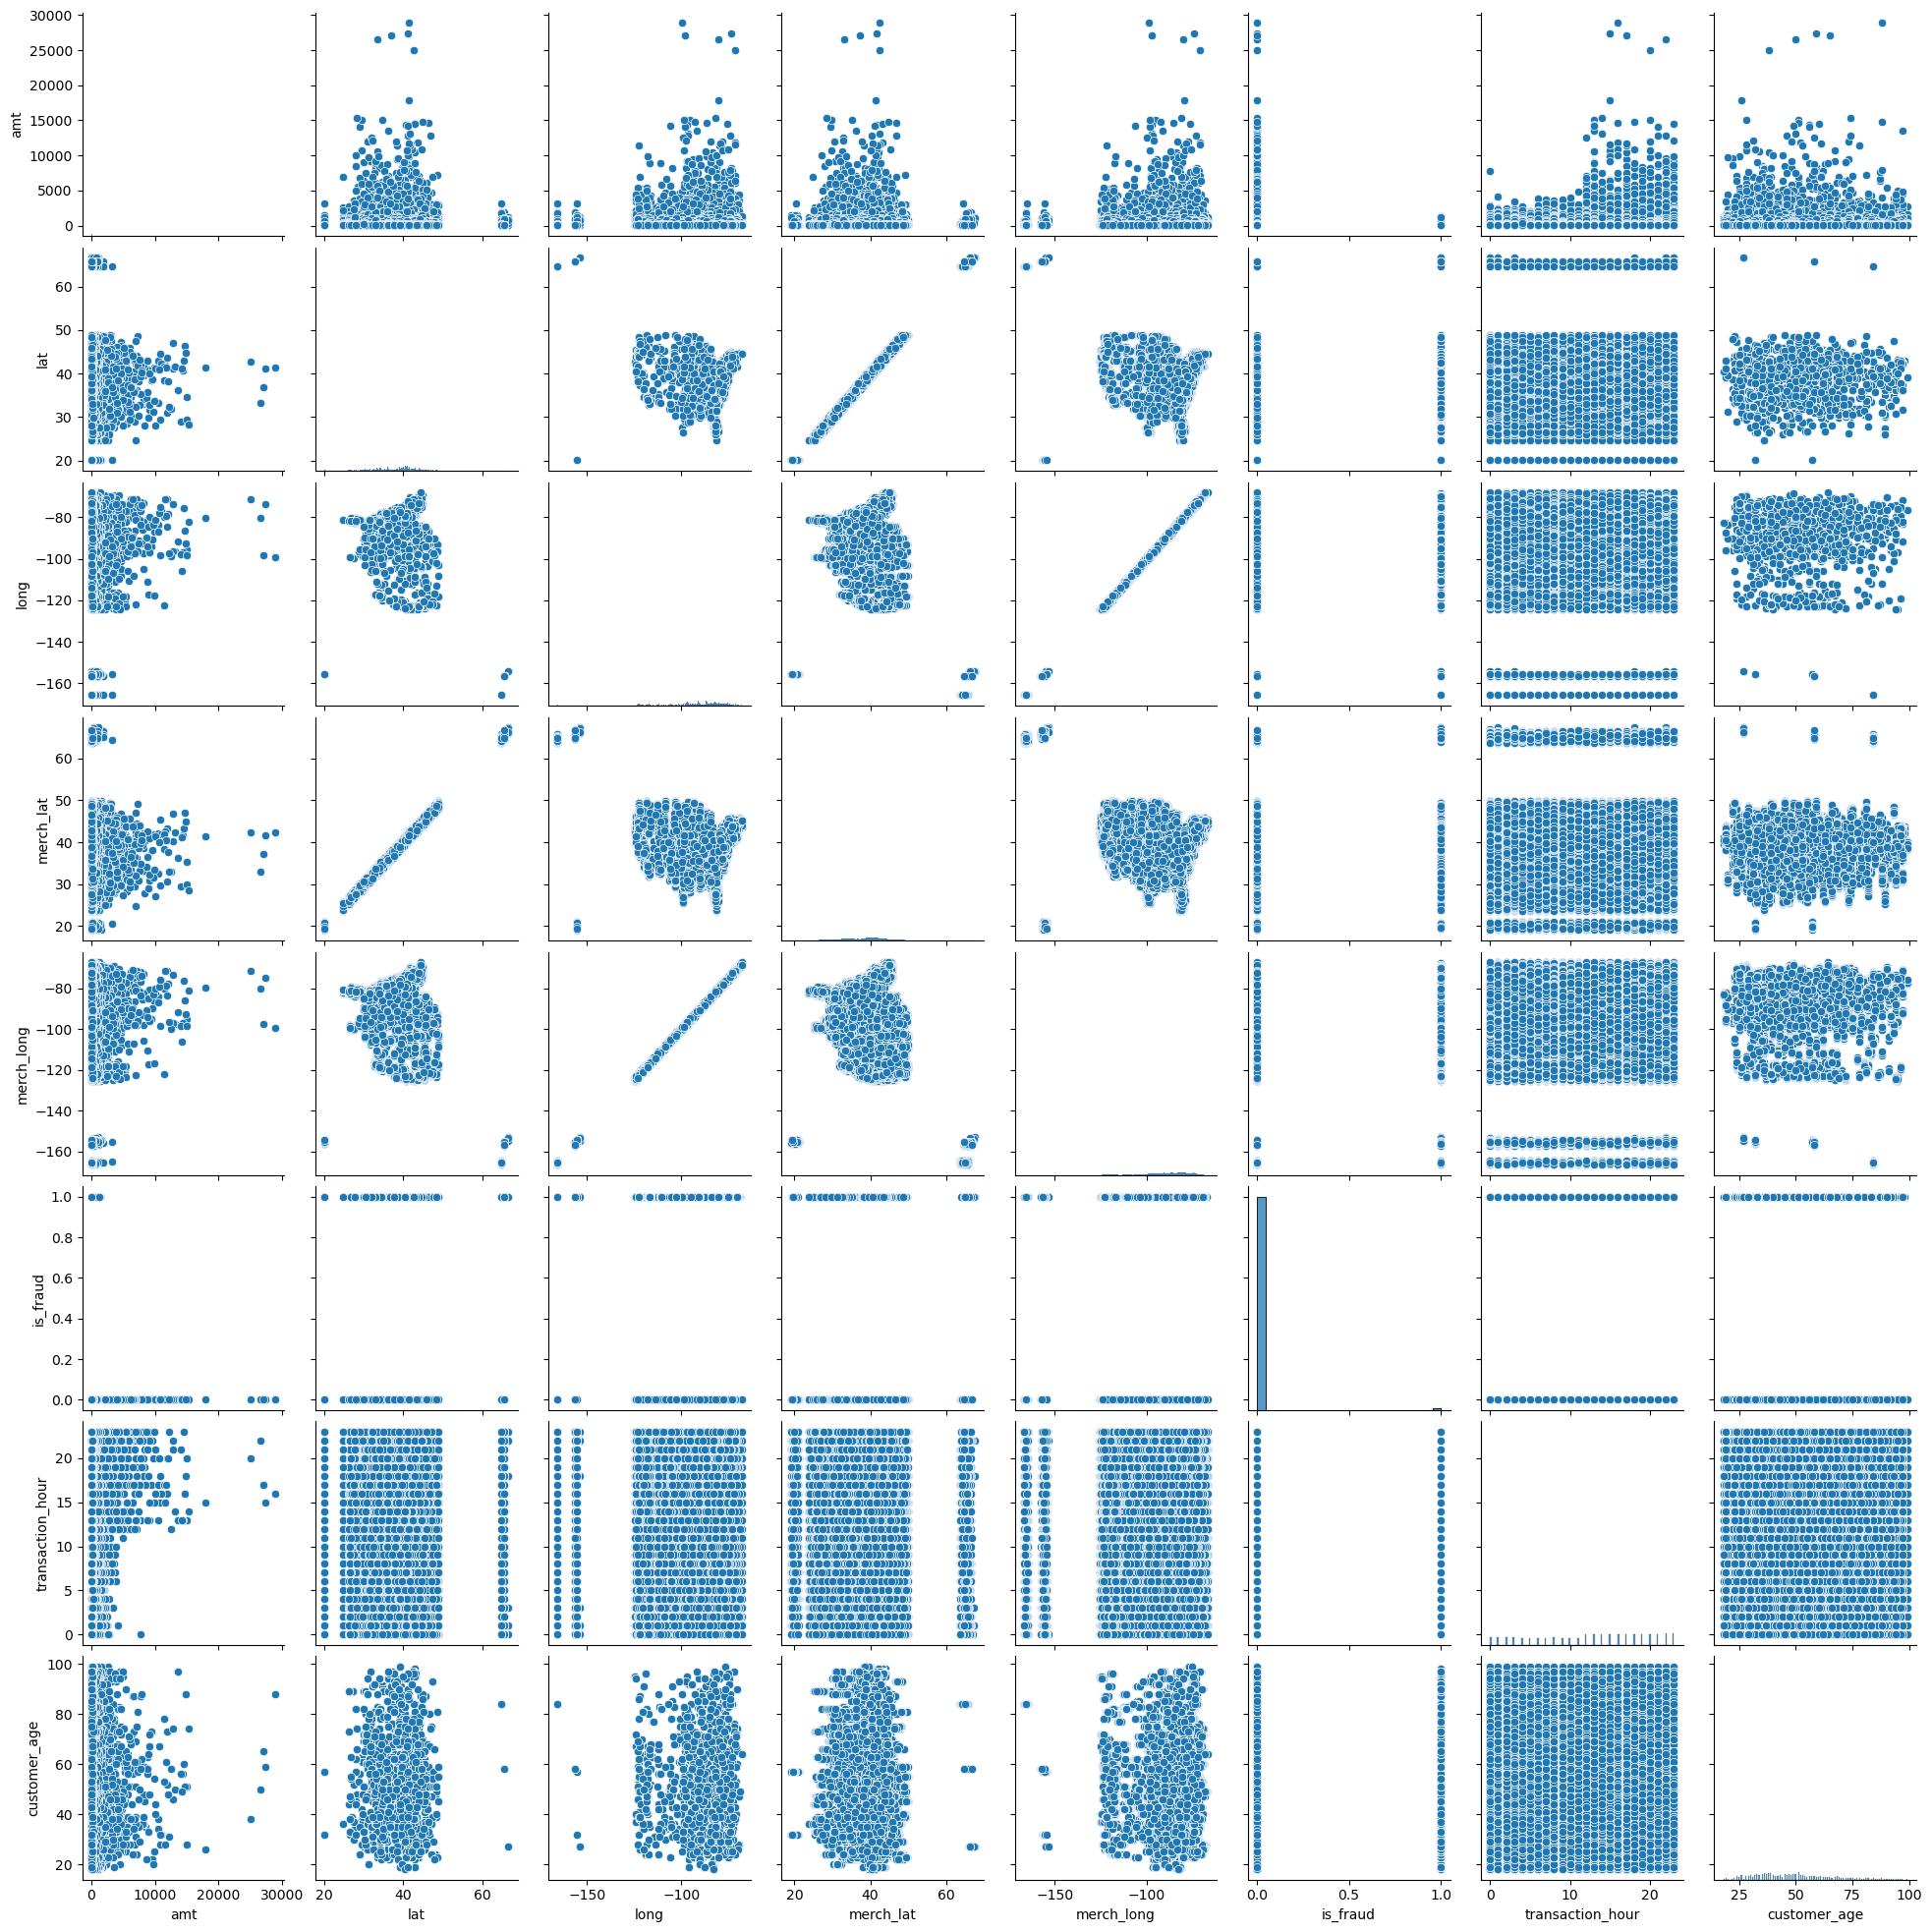

In [68]:
sns.pairplot(cleaned_up_df)

<Axes: >

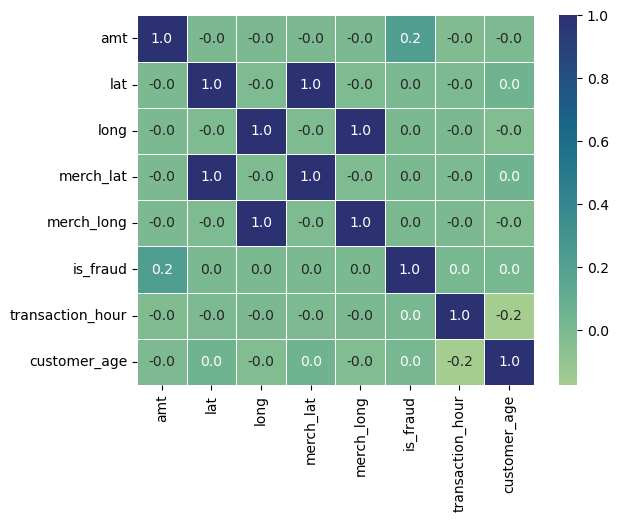

In [144]:
sns.heatmap(cleaned_up_df.corr(),annot=True,fmt='.1f',linewidth=.5,cmap="crest")

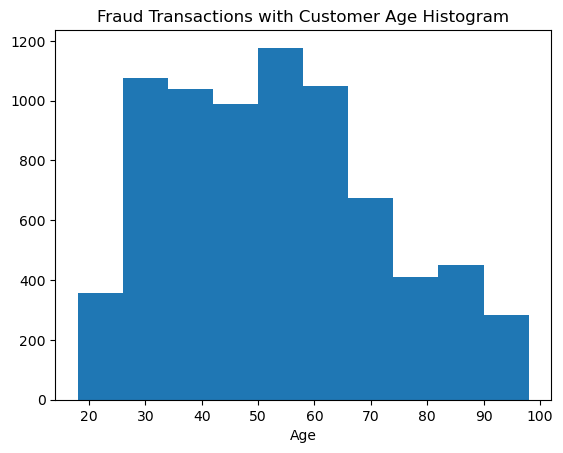

In [26]:
#create a fraud only dataset and understand how age impacts
fr_df = cleaned_up_df.query('is_fraud == 1')
plt.title('Fraud Transactions with Customer Age Histogram')
plt.hist(fr_df['customer_age'])
plt.xlabel('Age')
plt.show()

The above histogram shows that 30-60 years age people are victims of fraud transactions than other age people.

#### Scale Features

In [27]:
# used StandardScaler to scale the features.
X = StandardScaler().fit_transform(X)

### Classification Model Building
Lets build some of the classification models and evaluate performance of them. Here are the models im considering for this use case
* LogisticRegression
* KNN
* DecisionTreeClassifier
* SVM
* GaussianNB
* MultinomialNB
* SGDClassifier

#### Split the data

In [28]:
# split the dataset with test set size of 30%  of the dataset.
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.3,random_state=42)

#### Helper methods and data structures

In [40]:
# function to plot the confusion matrix
def plot_confusion_matrix(y_test,classifier,X_test,title): 
    cm = confusion_matrix(y_test,classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
    disp.plot()
    disp.ax_.set_title(title)


# build a method to tune hyper parameters of various models using GridSearchCV
def hyper_parameter_tuning(model,grid_params):
    gs = GridSearchCV(model,param_grid=grid_params, scoring="accuracy", cv=5,n_jobs=-1).fit(X_train,y_train)
    return gs

# dictionary to track each model's accuracy and scores.
model_test_scores = {}
balanced_accuracy_scores_dict = {}
precision_dict = {}
recall_dict = {}
f1_score_dict = {}



# track scores
def measure_scores(clf,X_test,y_test,model_name):
    y_preds = clf.predict(X_test)
    balanced_accuracy_scores_dict[model_name] = balanced_accuracy_score(y_test,y_preds)
    precision,recall,f1,support = precision_recall_fscore_support(y_test,y_preds,average='binary')
    precision_dict[model_name] = precision
    recall_dict[model_name] = recall
    f1_score_dict[model_name] = f1
    model_test_scores[model_name]=clf.score(X_test,y_test)


#### Base Models
Lets look at LogisticRegression,KNN and SGDClassifier with default hyper parameters and see how these models perform on this dataset.

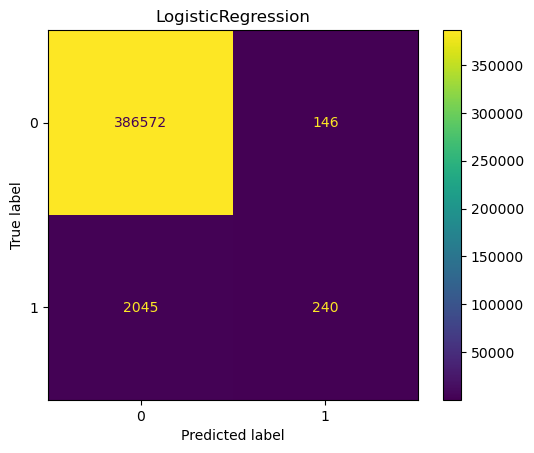

In [30]:
lgr = LogisticRegression().fit(X_train,y_train)
plot_confusion_matrix(y_test,lgr,X_test,'LogisticRegression')

#measure performance
measure_scores(lgr,X_test,y_test,'LogisticRegression')

In [31]:
f1_score_dict['LogisticRegression']

0.17970797454137027

Trained the base **LogisticRegression** using default hyper parameters and the above confusion matrix shows the accuracy of prediction of the fraud transactions.

It shows that  this model predicts only **True Negatives** but not **True Positives**. The **f1_score** of the model is only 17% which is not so great so technically  we cannot use this model as it will say every transaction is not a fraud one.


#### Hyper Parameter Tuning
Tune the hyperparameter of various classification models and evaluate the performance

##### Logistic Regression

LogisticRegression(n_jobs=-1)


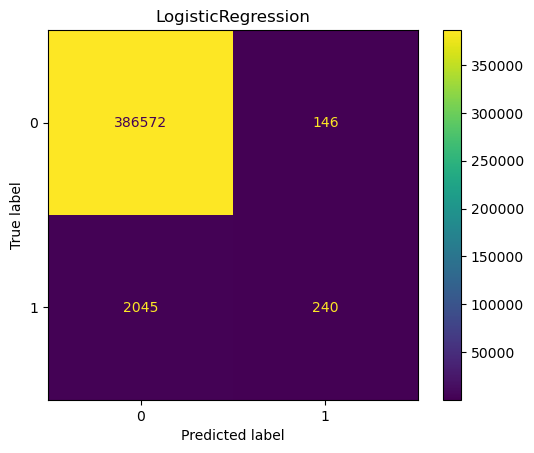

In [34]:
log_reg = LogisticRegression(n_jobs=-1)
parameters = {
    "penalty":["l1", "l2", "elasticnet"],
    "C": [0.1,0.5,1.0],
    "max_iter": [100,1000,2000,5000]
}
log_reg_gs = hyper_parameter_tuning(log_reg,parameters)
print(log_reg_gs.best_estimator_)
plot_confusion_matrix(y_test,log_reg_gs,X_test,'LogisticRegression')
measure_scores(log_reg_gs,X_test,y_test,'LogisticRegression')

In [35]:
f1_score_dict['LogisticRegression']

0.17970797454137027

Even after tuning hyper parameters of the LogisticRegression the model didnt improved much. Lets evaluate other models and see.

#### KNN

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)


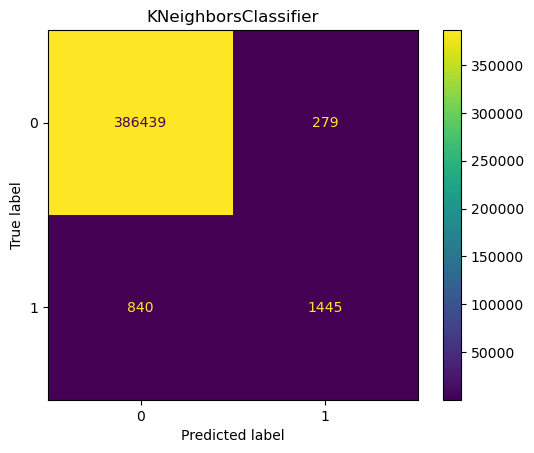

In [36]:
knn_m = KNeighborsClassifier(n_jobs=-1)
params = {
    "n_neighbors": np.array(range(1,5))
}
knn_gs = hyper_parameter_tuning(knn_m,params)
print(knn_gs.best_estimator_)
plot_confusion_matrix(y_test,knn_gs,X_test,'KNeighborsClassifier')
measure_scores(knn_gs,X_test,y_test,'KNeighborsClassifier')

In [38]:
print(f1_score_dict['KNeighborsClassifier'],balanced_accuracy_scores_dict['KNeighborsClassifier'])

0.7208780244449987 0.8158318322027338


KNN improved much with n_neighbors of 3, the f1_score is 72% and the balanced accuracy score is 81%.

##### DecisionTreeClassifier

DecisionTreeClassifier(max_depth=12)


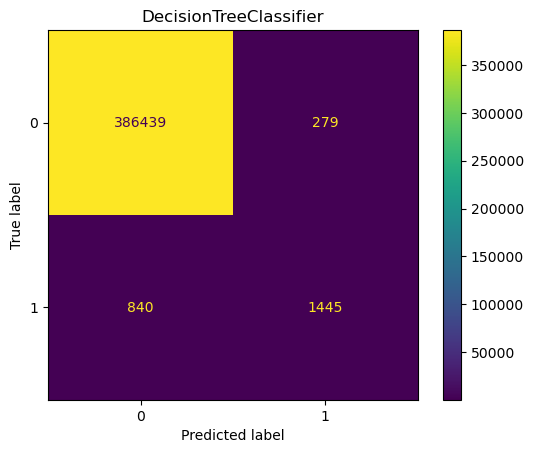

In [43]:
tree_m = DecisionTreeClassifier()
tree_parameter = {
"max_depth": np.array(range(1,15))
}
tree_gs = hyper_parameter_tuning(tree_m,tree_parameter)
print(tree_gs.best_estimator_)
plot_confusion_matrix(y_test,knn_gs,X_test,'DecisionTreeClassifier')
measure_scores(knn_gs,X_test,y_test,'DecisionTreeClassifier')

In [44]:
print(f1_score_dict['DecisionTreeClassifier'],balanced_accuracy_scores_dict['DecisionTreeClassifier'])

0.7208780244449987 0.8158318322027338


DecisionTreeClassifier with max depth of 12 is performing at 72% of f1_score and balanced accuracy is 81.5% which is close to KNN but is not reaching our goal.

##### SVM(SVC)

In [ ]:
svc = SVC()
svc_param_grid = {
    "gamma": [0.1, 1.0, 10, 100],
    "C": [0.1, 1.0, 10, 100]
}
svc_gs = hyper_parameter_tuning(svc,svc_param_grid)
print(svc_gs.best_estimator_)
plot_confusion_matrix(y_test,svc_gs,X_test,'SVC')
measure_scores(svc_gs,X_test,y_test,'SVC')


##### GuassianNB

In [ ]:
gnb = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gnb_gs = hyper_parameter_tuning(gnb,params_NB)
print(gnb_gs.best_estimator_)
plot_confusion_matrix(y_test,gnb_gs,X_test,'GaussianNB')
measure_scores(gnb_gs,X_test,y_test,'GaussianNB')

##### MultinomialNB

#### SGDClassifier

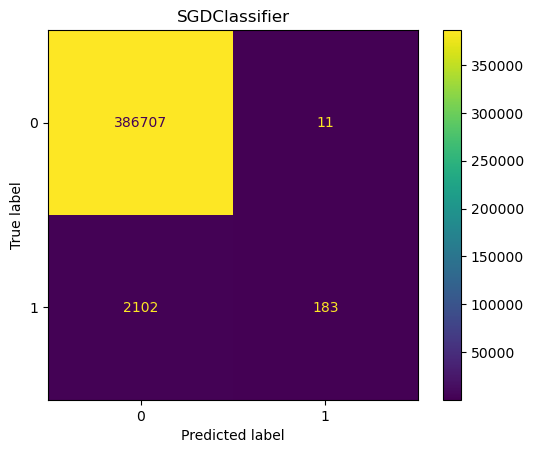

In [80]:
sgd = SGDClassifier().fit(X_train,y_train)
plot_confusion_matrix(y_test,sgd,X_test,'SGDClassifier')
measure_scores(sgd,X_test,y_test,'SGDClassifier')

In [133]:
print(f1_score_dict['SGDClassifier'])

0.14764017749092376


Base SGDClassifier didnt performed very well as its f1_score is 14% only.

#### Observations
Here are few points to note why they didn't performed well.
* The target classes imbalance.
* No hyper parameter tuning on all models.

### Balancing Target Classes

In this dataset there are only 1% of fraud transactions which made this models to not classify accurately  on the true positive records. There are some techniques we can use to balance this imbalance dataset. They are 
* Random Over Sampling
* BorderlineSMOTE
* SMOTE
* ADASYN

In [123]:
# A function to build a model using RandomForestClassifier with data using balancing techniques to evaluate the performance

def sampled_random_forest_performance(X_sampled,y_sampled,sample_algorithm):
    X_sampled_train,X_sampled_test,y_sampled_train,y_sampled_test = train_test_split(X_sampled,y_sampled,test_size=0.3,random_state=42)

    #train the model
    r_sampled = RandomForestClassifier(n_jobs=-1).fit(X_sampled_train,y_sampled_train)
    plot_confusion_matrix(y_sampled_test,r_sampled,X_sampled_test,'RandomForestClassifier_' + sample_algorithm)
    measure_scores(r_sampled,X_sampled_test,y_sampled_test,'RandomForestClassifier_' + sample_algorithm)    
    

#### RandomOverSampler

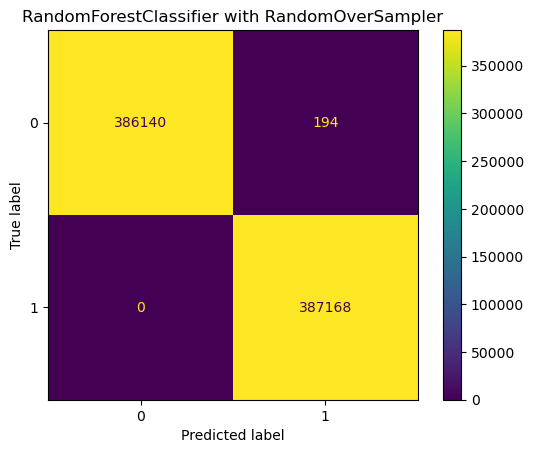

In [113]:
X_sampled,y_sampled = RandomOverSampler(random_state=42).fit_resample(X,y)
sampled_random_forest_performance(X_sampled,y_sampled,'RandomOverSampler')

#### BorderlineSMOTE

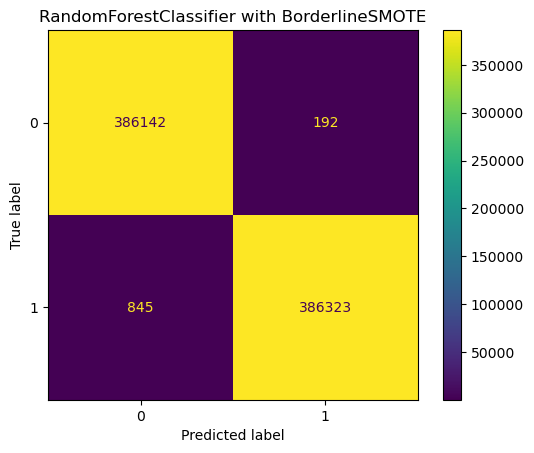

In [115]:
kms = BorderlineSMOTE(random_state=42)
X_km_sample,y_km_sample = kms.fit_resample(X,y)

sampled_random_forest_performance(X_km_sample,y_km_sample,'BorderlineSMOTE')

#### SMOTE

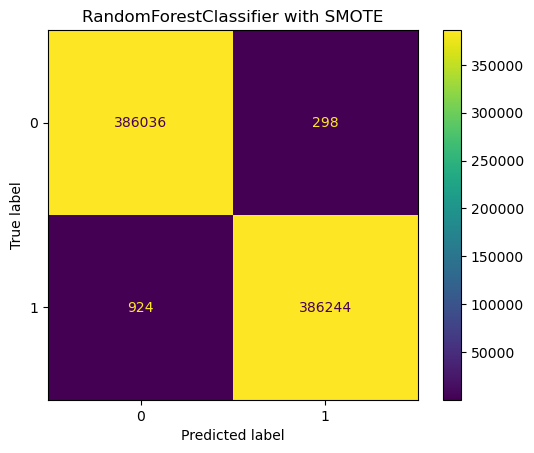

In [117]:
smote = SMOTE(random_state=42)
X_smote_sampled,y_smote_sampled = smote.fit_resample(X,y)
sampled_random_forest_performance(X_smote_sampled,y_smote_sampled,'SMOTE')

#### ADASYN

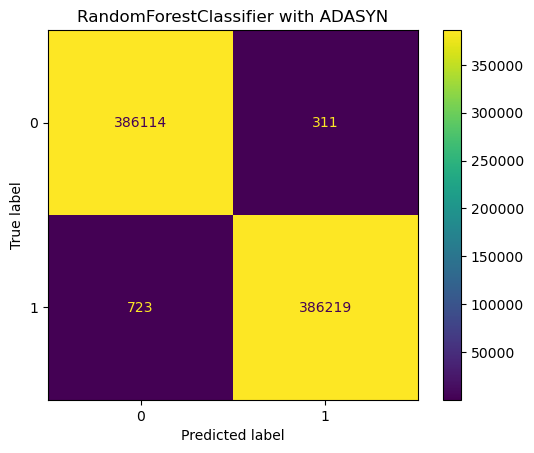

In [118]:
adasyn = ADASYN(random_state=42)
X_adasyn_sampled,y_adasyn_sampled = adasyn.fit_resample(X,y)
sampled_random_forest_performance(X_adasyn_sampled,y_adasyn_sampled,'ADASYN')

### Ensemble Techniques
Using the following ensemble techniques to evaluate the models and find out the best model.

* BaggingClassifier
* AdaBoostClassifier
* BalancedRandomForestClassifier
* RUSBoostingClassifier
* RandomForestClassifier

#### BaggingClassifier

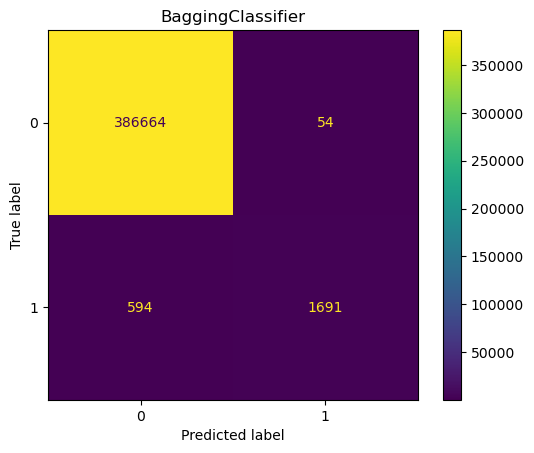

In [86]:
r_bc = RandomForestClassifier(n_jobs=-1)
bc = BaggingClassifier(base_estimator=r_bc,random_state=42).fit(X_train,y_train)
plot_confusion_matrix(y_test,bc,X_test,'BaggingClassifier')
measure_scores(bc,X_test,y_test,'BaggingClassifier')

#### AdaBoostingClassifier

In [ ]:
r = RandomForestClassifier(n_jobs=-1)
ada = AdaBoostClassifier(r).fit(X_train,y_train)
print('AdaBoostingClassifier Score: ' + ada.score(X_test,y_test))
plot_confusion_matrix(y_train,ada,X_train,'Confusion Matrix of AdaBoostClassifier on Train Data')
measure_scores(ada,X_test,y_test,'AdaBoostClassifier')

In [ ]:
plot_confusion_matrix(y_test,ada,X_test,'Confusion Matrix of AdaBoostClassifier on Test Data')

#### BalancedRandomForestClassifier

In [99]:
from imblearn.ensemble import BalancedRandomForestClassifier
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=0, sampling_strategy="all", replacement=True,n_jobs=-1).fit(X_train,y_train)
plot_confusion_matrix(y_test,brfc,X_test,'BalancedRandomForestClassifier on Test Data')
measure_scores(brfc,X_test,y_test,'BalancedRandomForestClassifier')

#### RUSBoostingClassifier

In [102]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0).fit(X_train,y_train)
plot_confusion_matrix(y_test,rusboost,X_test,'RUSBoostClassifier on Test Data')
measure_scores(rusboost,X_test,y_test,'RUSBoostClassifier')

In [115]:
balanced_accuracy_score(y_test,brfc.predict(X_test))

0.9660770467622481

#### RandomForestClassifier

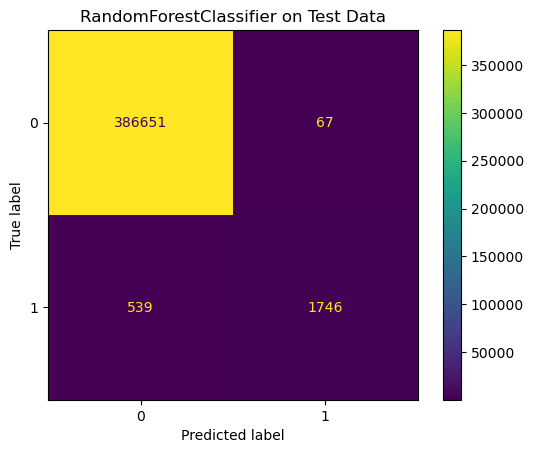

In [82]:
rfc = RandomForestClassifier(n_jobs=-1).fit(X_train,y_train)
plot_confusion_matrix(y_test,rfc,X_test,'RandomForestClassifier on Test Data')
measure_scores(rfc,X_test,y_test,'RandomForestClassifier')

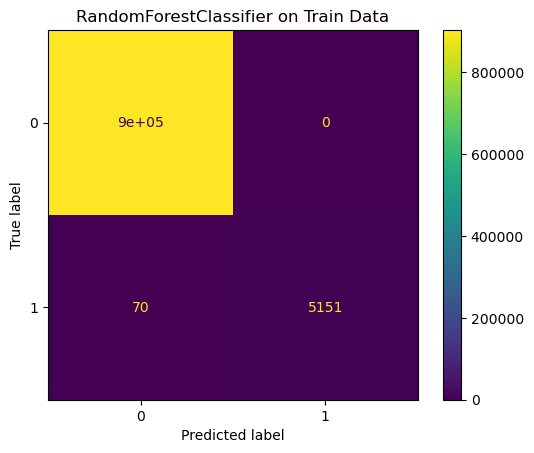

In [83]:
plot_confusion_matrix(y_train,rfc,X_train,'RandomForestClassifier on Train Data')

### Deep Neural Networks

Epoch 1/25
22692/22692 [==============================] - 45s 2ms/step - loss: 0.0172 - accuracy: 0.9962 - val_loss: 0.0131 - val_accuracy: 0.9968
Epoch 2/25
22692/22692 [==============================] - 44s 2ms/step - loss: 0.0118 - accuracy: 0.9969 - val_loss: 0.0144 - val_accuracy: 0.9972
Epoch 3/25
22692/22692 [==============================] - 44s 2ms/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.0109 - val_accuracy: 0.9975
Epoch 4/25
22692/22692 [==============================] - 43s 2ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0093 - val_accuracy: 0.9976
Epoch 5/25
22692/22692 [==============================] - 43s 2ms/step - loss: 0.0094 - accuracy: 0.9977 - val_loss: 0.0099 - val_accuracy: 0.9974
Epoch 6/25
22692/22692 [==============================] - 43s 2ms/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.0088 - val_accuracy: 0.9976
Epoch 7/25
22692/22692 [==============================] - 43s 2ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0

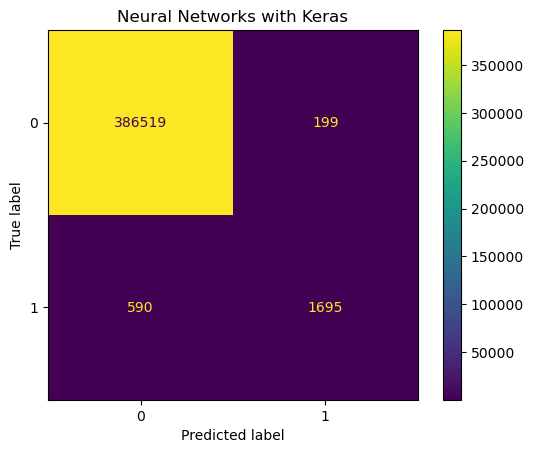

In [124]:
# create model
model = Sequential()
model.add(Dense(60, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
 # Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#evaluate the model
model.fit(X_train,y_train,epochs=25,batch_size=32,validation_split=0.2)

#plot the confusion matrix
y_preds = np.round(model.predict(X_test))
cm = confusion_matrix(y_test,y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
disp.ax_.set_title('Neural Networks with Keras')
plt.show()

In [125]:
# measure the performance
balanced_accuracy_scores_dict['Neural Net'] = balanced_accuracy_score(y_test,y_preds)
precision,recall,f1,support = precision_recall_fscore_support(y_test,y_preds,average='binary')
precision_dict['Neural Net'] = precision
recall_dict['Neural Net'] = recall
f1_score_dict['Neural Net'] = f1
model_test_scores['Neural Net']=model.evaluate(X_test,y_test)

12157/12157 [==============================] - 16s 1ms/step - loss: 0.0077 - accuracy: 0.9980


## Performance

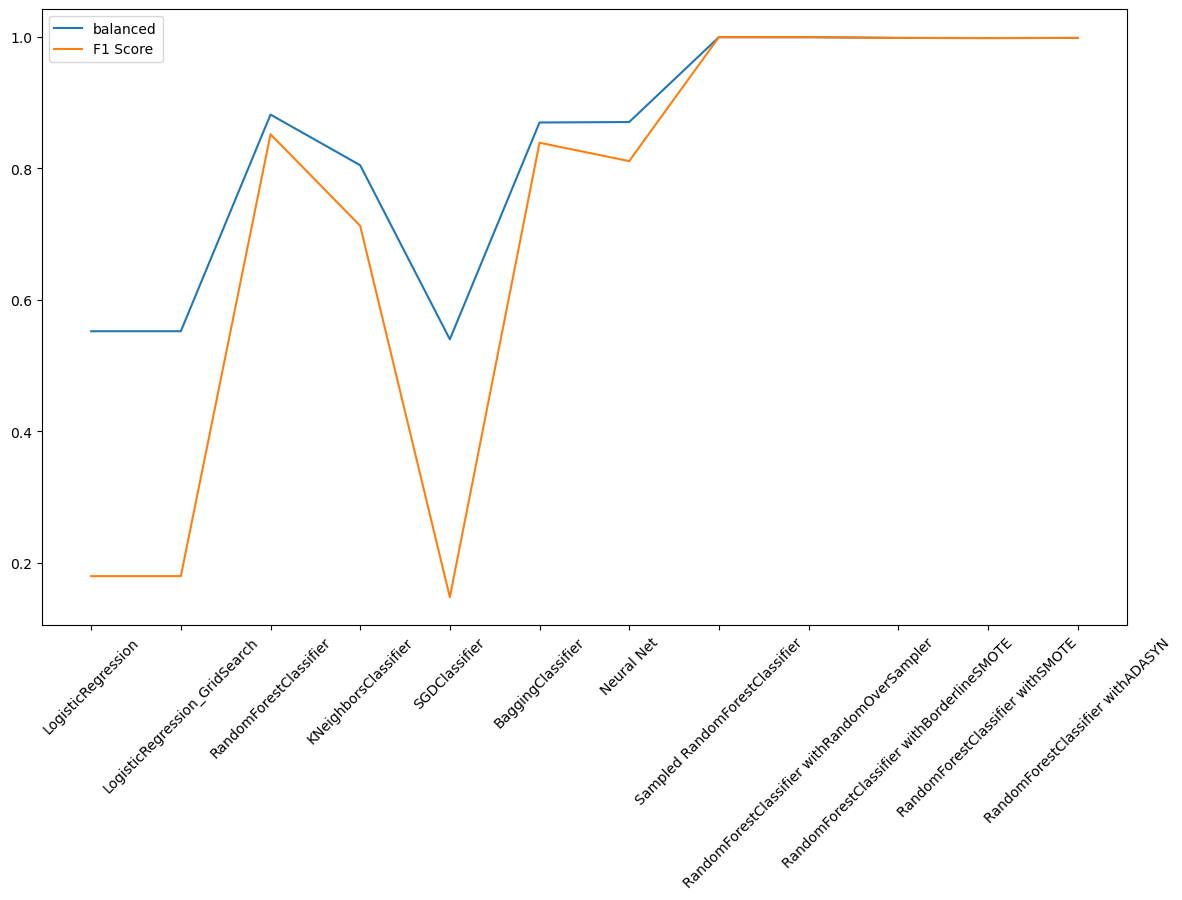

In [126]:
plt.figure(figsize=(14,8))
plt.plot(balanced_accuracy_scores_dict.keys(),balanced_accuracy_scores_dict.values(),label='balanced')
plt.plot(f1_score_dict.keys(),f1_score_dict.values(),label='F1 Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()